In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

     |████████████████████████████████| 6.6 MB 14.2 MB/s 
     |████████████████████████████████| 1.8 MB 80.5 MB/s 
     |████████████████████████████████| 1.2 MB 85.7 MB/s 
     |████████████████████████████████| 181 kB 89.7 MB/s 
     |████████████████████████████████| 145 kB 95.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1e4ac79d9a265fcbcda87c5212227764a6f81d77c154e8fa15a655886a939caa
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [6]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 13.5 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 89.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [9]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [10]:
OUTPUT_DIR = './pppm-bert-for-patents-outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 20 13:48:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=5
    encoder_lr=1e-5 #2e-5
    decoder_lr=1e-5 #2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=14
    fc_dropout=0.1
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    train_all_index=25
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [13]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Training', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [14]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [15]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [16]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [17]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        pattern = "^"+pattern[:-2]
        cpc_result = re.sub(pattern, "", result[0])
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            pattern = "^"+pattern[:-2]
            results[context] = cpc_result + ". " + re.sub(pattern, "", result[0])
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
# cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [18]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

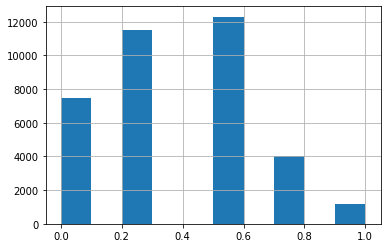

In [19]:
train['score'].hist()

In [20]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [21]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [22]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [23]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
# dfx = pd.get_dummies(train, columns=["score"]).groupby(["target"], as_index=False).sum()
# cols = [c for c in dfx.columns if c.startswith("score_") or c == "target"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
# labels = [c for c in dfx.columns if c != "target"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
# train = train.merge(dfx[["target", "fold"]], on="target", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [24]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [25]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

# Dataset

In [26]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 115


In [27]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [28]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [29]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
            # self.model = AutoModelForSequenceClassification.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            # self.model = AutoModelForSequenceClassification.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        # self.fc = nn.Linear(self.config.num_labels, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    
    # def forward(self, inputs):
    #     return self.model(**inputs)


# Helper Functions

In [30]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [31]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if fold != CFG.train_all_index:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    # criterion = nn.MSELoss()
    # criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2062] Elapsed 0m 0s (remain 24m 33s) Loss: 0.6868(0.6868) Grad: 358972.8438  LR: 0.00001000  
Epoch: [1][100/2062] Elapsed 0m 17s (remain 5m 41s) Loss: 0.6221(0.6534) Grad: 38013.8672  LR: 0.00001000  
Epoch: [1][200/2062] Elapsed 0m 34s (remain 5m 19s) Loss: 0.4996(0.6508) Grad: 44941.2734  LR: 0.00000999  
Epoch: [1][300/2062] Elapsed 0m 51s (remain 4m 59s) Loss: 0.4958(0.6360) Grad: 19963.8262  LR: 0.00000998  
Epoch: [1][400/2062] Elapsed 1m 8s (remain 4m 41s) Loss: 0.6273(0.6260) Grad: 19223.6562  LR: 0.00000996  
Epoch: [1][500/2062] Elapsed 1m 24s (remain 4m 24s) Loss: 0.6486(0.6173) Grad: 10516.0156  LR: 0.00000994  
Epoch: [1][600/2062] Elapsed 1m 41s (remain 4m 6s) Loss: 0.5003(0.6099) Grad: 7939.2178  LR: 0.00000992  
Epoch: [1][700/2062] Elapsed 1m 58s (remain 3m 49s) Loss: 0.5429(0.6041) Grad: 24172.2188  LR: 0.00000989  
Epoch: [1][800/2062] Elapsed 2m 15s (remain 3m 32s) Loss: 0.6180(0.5994) Grad: 5443.8008  LR: 0.00000985  
Epoch: [1][900/2062] Elapsed 2m 3

Epoch 1 - avg_train_loss: 0.5702  avg_val_loss: 0.5494  time: 401s
Epoch 1 - Score: 0.8049
Epoch 1 - Save Best Score: 0.8049 Model


EVAL: [542/543] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6269(0.5494) 
Epoch: [2][0/2062] Elapsed 0m 0s (remain 18m 34s) Loss: 0.4589(0.4589) Grad: 287813.1250  LR: 0.00000904  
Epoch: [2][100/2062] Elapsed 0m 17s (remain 5m 44s) Loss: 0.5677(0.5203) Grad: 187828.9062  LR: 0.00000895  
Epoch: [2][200/2062] Elapsed 0m 34s (remain 5m 23s) Loss: 0.5003(0.5123) Grad: 47690.5234  LR: 0.00000886  
Epoch: [2][300/2062] Elapsed 0m 51s (remain 5m 3s) Loss: 0.5251(0.5183) Grad: 119669.9219  LR: 0.00000876  
Epoch: [2][400/2062] Elapsed 1m 8s (remain 4m 44s) Loss: 0.5117(0.5211) Grad: 42367.1328  LR: 0.00000866  
Epoch: [2][500/2062] Elapsed 1m 25s (remain 4m 25s) Loss: 0.4931(0.5214) Grad: 100578.2422  LR: 0.00000855  
Epoch: [2][600/2062] Elapsed 1m 42s (remain 4m 8s) Loss: 0.5373(0.5201) Grad: 91231.7812  LR: 0.00000844  
Epoch: [2][700/2062] Elapsed 1m 58s (remain 3m 50s) Loss: 0.4765(0.5194) Grad: 154930.6719  LR: 0.00000833  
Epoch: [2][800/2062] Elapsed 2m 15s (remain 3m 33s) Loss: 0.5543(0.5

Epoch 2 - avg_train_loss: 0.5171  avg_val_loss: 0.5519  time: 401s
Epoch 2 - Score: 0.8139
Epoch 2 - Save Best Score: 0.8139 Model


EVAL: [542/543] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5675(0.5519) 
Epoch: [3][0/2062] Elapsed 0m 0s (remain 18m 59s) Loss: 0.5238(0.5238) Grad: 72446.6562  LR: 0.00000655  
Epoch: [3][100/2062] Elapsed 0m 17s (remain 5m 43s) Loss: 0.4909(0.5128) Grad: 167401.6562  LR: 0.00000640  
Epoch: [3][200/2062] Elapsed 0m 34s (remain 5m 23s) Loss: 0.5698(0.5148) Grad: 72887.9766  LR: 0.00000625  
Epoch: [3][300/2062] Elapsed 0m 51s (remain 5m 2s) Loss: 0.5260(0.5134) Grad: 41757.7383  LR: 0.00000611  
Epoch: [3][400/2062] Elapsed 1m 8s (remain 4m 42s) Loss: 0.4895(0.5097) Grad: 74064.1094  LR: 0.00000596  
Epoch: [3][500/2062] Elapsed 1m 24s (remain 4m 24s) Loss: 0.4908(0.5105) Grad: 91234.0625  LR: 0.00000581  
Epoch: [3][600/2062] Elapsed 1m 41s (remain 4m 6s) Loss: 0.4460(0.5122) Grad: 68414.9844  LR: 0.00000566  
Epoch: [3][700/2062] Elapsed 1m 58s (remain 3m 49s) Loss: 0.5297(0.5119) Grad: 123444.8438  LR: 0.00000550  
Epoch: [3][800/2062] Elapsed 2m 15s (remain 3m 32s) Loss: 0.5112(0.5103

Epoch 3 - avg_train_loss: 0.5095  avg_val_loss: 0.5565  time: 400s
Epoch 3 - Score: 0.8125


EVAL: [542/543] Elapsed 0m 52s (remain 0m 0s) Loss: 0.5386(0.5565) 
Epoch: [4][0/2062] Elapsed 0m 0s (remain 18m 10s) Loss: 0.6103(0.6103) Grad: 97429.2500  LR: 0.00000346  
Epoch: [4][100/2062] Elapsed 0m 17s (remain 5m 38s) Loss: 0.5626(0.4927) Grad: 69768.0625  LR: 0.00000331  
Epoch: [4][200/2062] Elapsed 0m 34s (remain 5m 17s) Loss: 0.5730(0.4890) Grad: 114251.4062  LR: 0.00000317  
Epoch: [4][300/2062] Elapsed 0m 51s (remain 4m 58s) Loss: 0.6621(0.4917) Grad: 94934.2344  LR: 0.00000303  
Epoch: [4][400/2062] Elapsed 1m 7s (remain 4m 41s) Loss: 0.4574(0.4950) Grad: 21178.4961  LR: 0.00000289  
Epoch: [4][500/2062] Elapsed 1m 24s (remain 4m 23s) Loss: 0.6360(0.4971) Grad: 41522.7344  LR: 0.00000275  
Epoch: [4][600/2062] Elapsed 1m 41s (remain 4m 6s) Loss: 0.6218(0.4981) Grad: 36563.9609  LR: 0.00000262  
Epoch: [4][700/2062] Elapsed 1m 58s (remain 3m 49s) Loss: 0.5314(0.4982) Grad: 78505.3047  LR: 0.00000249  
Epoch: [4][800/2062] Elapsed 2m 15s (remain 3m 32s) Loss: 0.4979(0.5000

Epoch 4 - avg_train_loss: 0.5028  avg_val_loss: 0.5644  time: 400s
Epoch 4 - Score: 0.8129


EVAL: [542/543] Elapsed 0m 52s (remain 0m 0s) Loss: 0.5098(0.5644) 
Epoch: [5][0/2062] Elapsed 0m 0s (remain 18m 53s) Loss: 0.4513(0.4513) Grad: 64300.3555  LR: 0.00000096  
Epoch: [5][100/2062] Elapsed 0m 17s (remain 5m 35s) Loss: 0.5535(0.4955) Grad: 109691.0391  LR: 0.00000087  
Epoch: [5][200/2062] Elapsed 0m 34s (remain 5m 15s) Loss: 0.4912(0.4921) Grad: 164214.5625  LR: 0.00000079  
Epoch: [5][300/2062] Elapsed 0m 50s (remain 4m 57s) Loss: 0.5504(0.4920) Grad: 250262.9688  LR: 0.00000071  
Epoch: [5][400/2062] Elapsed 1m 7s (remain 4m 40s) Loss: 0.4752(0.4919) Grad: 42833.0859  LR: 0.00000063  
Epoch: [5][500/2062] Elapsed 1m 24s (remain 4m 23s) Loss: 0.5842(0.4944) Grad: 67872.4141  LR: 0.00000056  
Epoch: [5][600/2062] Elapsed 1m 41s (remain 4m 6s) Loss: 0.4448(0.4939) Grad: 61511.1758  LR: 0.00000049  
Epoch: [5][700/2062] Elapsed 1m 57s (remain 3m 49s) Loss: 0.4482(0.4932) Grad: 49514.9219  LR: 0.00000043  
Epoch: [5][800/2062] Elapsed 2m 14s (remain 3m 32s) Loss: 0.6572(0.49

Epoch 5 - avg_train_loss: 0.4974  avg_val_loss: 0.5658  time: 400s
Epoch 5 - Score: 0.8122


EVAL: [542/543] Elapsed 0m 52s (remain 0m 0s) Loss: 0.5043(0.5658) 


========== fold: 0 result ==========
Score: 0.8139
========== fold: 1 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2105] Elapsed 0m 0s (remain 14m 42s) Loss: 0.7098(0.7098) Grad: 186867.4844  LR: 0.00001000  
Epoch: [1][100/2105] Elapsed 0m 17s (remain 5m 41s) Loss: 0.6677(0.6619) Grad: 34877.3711  LR: 0.00001000  
Epoch: [1][200/2105] Elapsed 0m 33s (remain 5m 21s) Loss: 0.5397(0.6565) Grad: 50507.6758  LR: 0.00000999  
Epoch: [1][300/2105] Elapsed 0m 50s (remain 5m 3s) Loss: 0.6221(0.6434) Grad: 55458.4414  LR: 0.00000998  
Epoch: [1][400/2105] Elapsed 1m 7s (remain 4m 46s) Loss: 0.6766(0.6303) Grad: 55137.2852  LR: 0.00000996  
Epoch: [1][500/2105] Elapsed 1m 24s (remain 4m 29s) Loss: 0.5909(0.6229) Grad: 17694.8047  LR: 0.00000994  
Epoch: [1][600/2105] Elapsed 1m 41s (remain 4m 13s) Loss: 0.4800(0.6168) Grad: 7347.2476  LR: 0.00000992  
Epoch: [1][700/2105] Elapsed 1m 58s (remain 3m 56s) Loss: 0.4935(0.6097) Grad: 10941.8770  LR: 0.00000989  
Epoch: [1][800/2105] Elapsed 2m 14s (remain 3m 39s) Loss: 0.9060(0.6062) Grad: 30024.2480  LR: 0.00000986  
Epoch: [1][900/2105] Elapsed 2m 

Epoch 1 - avg_train_loss: 0.5726  avg_val_loss: 0.5671  time: 403s
Epoch 1 - Score: 0.7907
Epoch 1 - Save Best Score: 0.7907 Model


EVAL: [499/500] Elapsed 0m 48s (remain 0m 0s) Loss: 0.6272(0.5671) 
Epoch: [2][0/2105] Elapsed 0m 0s (remain 16m 41s) Loss: 0.5388(0.5388) Grad: 49009.0195  LR: 0.00000904  
Epoch: [2][100/2105] Elapsed 0m 17s (remain 5m 48s) Loss: 0.5834(0.5381) Grad: 54014.3008  LR: 0.00000896  
Epoch: [2][200/2105] Elapsed 0m 34s (remain 5m 29s) Loss: 0.5163(0.5376) Grad: 38689.7188  LR: 0.00000886  
Epoch: [2][300/2105] Elapsed 0m 51s (remain 5m 9s) Loss: 0.5533(0.5365) Grad: 54830.7148  LR: 0.00000877  
Epoch: [2][400/2105] Elapsed 1m 8s (remain 4m 51s) Loss: 0.4925(0.5345) Grad: 10543.9971  LR: 0.00000867  
Epoch: [2][500/2105] Elapsed 1m 25s (remain 4m 33s) Loss: 0.6172(0.5309) Grad: 109930.3984  LR: 0.00000856  
Epoch: [2][600/2105] Elapsed 1m 42s (remain 4m 15s) Loss: 0.5769(0.5307) Grad: 37930.9023  LR: 0.00000846  
Epoch: [2][700/2105] Elapsed 1m 59s (remain 3m 58s) Loss: 0.5351(0.5284) Grad: 58115.7539  LR: 0.00000835  
Epoch: [2][800/2105] Elapsed 2m 15s (remain 3m 41s) Loss: 0.4494(0.5263

Epoch 2 - avg_train_loss: 0.5211  avg_val_loss: 0.5629  time: 405s
Epoch 2 - Score: 0.8113
Epoch 2 - Save Best Score: 0.8113 Model


EVAL: [499/500] Elapsed 0m 48s (remain 0m 0s) Loss: 0.5204(0.5629) 
Epoch: [3][0/2105] Elapsed 0m 0s (remain 21m 23s) Loss: 0.5406(0.5406) Grad: 108791.2812  LR: 0.00000654  
Epoch: [3][100/2105] Elapsed 0m 18s (remain 5m 59s) Loss: 0.6074(0.5133) Grad: 99765.8984  LR: 0.00000640  
Epoch: [3][200/2105] Elapsed 0m 35s (remain 5m 39s) Loss: 0.3885(0.5151) Grad: 44116.4141  LR: 0.00000626  
Epoch: [3][300/2105] Elapsed 0m 52s (remain 5m 16s) Loss: 0.6415(0.5114) Grad: 49404.6094  LR: 0.00000611  
Epoch: [3][400/2105] Elapsed 1m 9s (remain 4m 56s) Loss: 0.5000(0.5106) Grad: 62943.5039  LR: 0.00000597  
Epoch: [3][500/2105] Elapsed 1m 26s (remain 4m 38s) Loss: 0.4653(0.5085) Grad: 72280.3125  LR: 0.00000582  
Epoch: [3][600/2105] Elapsed 1m 43s (remain 4m 19s) Loss: 0.6228(0.5078) Grad: 228710.7812  LR: 0.00000567  
Epoch: [3][700/2105] Elapsed 2m 0s (remain 4m 1s) Loss: 0.6336(0.5079) Grad: 55631.5039  LR: 0.00000553  
Epoch: [3][800/2105] Elapsed 2m 17s (remain 3m 43s) Loss: 0.5346(0.5081

Epoch 3 - avg_train_loss: 0.5082  avg_val_loss: 0.5665  time: 406s
Epoch 3 - Score: 0.8116
Epoch 3 - Save Best Score: 0.8116 Model


EVAL: [499/500] Elapsed 0m 48s (remain 0m 0s) Loss: 0.5205(0.5665) 
Epoch: [4][0/2105] Elapsed 0m 0s (remain 21m 1s) Loss: 0.3985(0.3985) Grad: 50996.2891  LR: 0.00000346  
Epoch: [4][100/2105] Elapsed 0m 18s (remain 5m 57s) Loss: 0.6028(0.5031) Grad: 172631.2969  LR: 0.00000331  
Epoch: [4][200/2105] Elapsed 0m 35s (remain 5m 37s) Loss: 0.5113(0.5039) Grad: 121536.7422  LR: 0.00000317  
Epoch: [4][300/2105] Elapsed 0m 52s (remain 5m 15s) Loss: 0.5735(0.5048) Grad: 103164.4297  LR: 0.00000304  
Epoch: [4][400/2105] Elapsed 1m 9s (remain 4m 56s) Loss: 0.5393(0.5035) Grad: 47298.2383  LR: 0.00000290  
Epoch: [4][500/2105] Elapsed 1m 26s (remain 4m 37s) Loss: 0.5643(0.5015) Grad: 167757.0625  LR: 0.00000277  
Epoch: [4][600/2105] Elapsed 1m 43s (remain 4m 19s) Loss: 0.5144(0.5008) Grad: 306247.5312  LR: 0.00000263  
Epoch: [4][700/2105] Elapsed 2m 0s (remain 4m 1s) Loss: 0.5701(0.5010) Grad: 41575.4766  LR: 0.00000250  
Epoch: [4][800/2105] Elapsed 2m 17s (remain 3m 43s) Loss: 0.5212(0.50

Epoch 4 - avg_train_loss: 0.5015  avg_val_loss: 0.5690  time: 406s
Epoch 4 - Score: 0.8114


EVAL: [499/500] Elapsed 0m 48s (remain 0m 0s) Loss: 0.5181(0.5690) 
Epoch: [5][0/2105] Elapsed 0m 0s (remain 20m 48s) Loss: 0.5003(0.5003) Grad: 89143.3203  LR: 0.00000096  
Epoch: [5][100/2105] Elapsed 0m 17s (remain 5m 45s) Loss: 0.4914(0.4919) Grad: 388150.3438  LR: 0.00000087  
Epoch: [5][200/2105] Elapsed 0m 34s (remain 5m 25s) Loss: 0.3107(0.4951) Grad: 66670.0703  LR: 0.00000079  
Epoch: [5][300/2105] Elapsed 0m 51s (remain 5m 7s) Loss: 0.4525(0.4971) Grad: 22955.7207  LR: 0.00000071  
Epoch: [5][400/2105] Elapsed 1m 8s (remain 4m 50s) Loss: 0.4977(0.4987) Grad: 32431.1680  LR: 0.00000063  
Epoch: [5][500/2105] Elapsed 1m 25s (remain 4m 33s) Loss: 0.5194(0.4996) Grad: 149208.4375  LR: 0.00000056  
Epoch: [5][600/2105] Elapsed 1m 42s (remain 4m 16s) Loss: 0.5896(0.4992) Grad: 113207.5938  LR: 0.00000050  
Epoch: [5][700/2105] Elapsed 1m 59s (remain 3m 58s) Loss: 0.5871(0.4987) Grad: 69250.0781  LR: 0.00000043  
Epoch: [5][800/2105] Elapsed 2m 15s (remain 3m 41s) Loss: 0.4693(0.49

Epoch 5 - avg_train_loss: 0.4982  avg_val_loss: 0.5727  time: 405s
Epoch 5 - Score: 0.8094


EVAL: [499/500] Elapsed 0m 48s (remain 0m 0s) Loss: 0.5172(0.5727) 


========== fold: 1 result ==========
Score: 0.8116
========== fold: 2 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2056] Elapsed 0m 0s (remain 16m 8s) Loss: 0.6801(0.6801) Grad: inf  LR: 0.00001000  
Epoch: [1][100/2056] Elapsed 0m 17s (remain 5m 33s) Loss: 0.5866(0.6598) Grad: 38442.4258  LR: 0.00001000  
Epoch: [1][200/2056] Elapsed 0m 33s (remain 5m 13s) Loss: 0.6550(0.6457) Grad: 46504.7109  LR: 0.00000999  
Epoch: [1][300/2056] Elapsed 0m 50s (remain 4m 55s) Loss: 0.6406(0.6375) Grad: 41757.9062  LR: 0.00000998  
Epoch: [1][400/2056] Elapsed 1m 7s (remain 4m 38s) Loss: 0.6712(0.6269) Grad: 50399.4805  LR: 0.00000996  
Epoch: [1][500/2056] Elapsed 1m 24s (remain 4m 21s) Loss: 0.5145(0.6188) Grad: 38425.7383  LR: 0.00000994  
Epoch: [1][600/2056] Elapsed 1m 40s (remain 4m 4s) Loss: 0.6730(0.6124) Grad: 31130.2598  LR: 0.00000992  
Epoch: [1][700/2056] Elapsed 1m 57s (remain 3m 47s) Loss: 0.6354(0.6064) Grad: 30503.6934  LR: 0.00000989  
Epoch: [1][800/2056] Elapsed 2m 14s (remain 3m 30s) Loss: 0.7114(0.6039) Grad: 57265.2539  LR: 0.00000985  
Epoch: [1][900/2056] Elapsed 2m 31s (rem

Epoch 1 - avg_train_loss: 0.5758  avg_val_loss: 0.5610  time: 399s
Epoch 1 - Score: 0.8130
Epoch 1 - Save Best Score: 0.8130 Model


EVAL: [548/549] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4217(0.5610) 
Epoch: [2][0/2056] Elapsed 0m 0s (remain 20m 22s) Loss: 0.5719(0.5719) Grad: 137626.6719  LR: 0.00000904  
Epoch: [2][100/2056] Elapsed 0m 18s (remain 5m 50s) Loss: 0.3939(0.5276) Grad: 31696.1992  LR: 0.00000895  
Epoch: [2][200/2056] Elapsed 0m 35s (remain 5m 29s) Loss: 0.5665(0.5303) Grad: 93789.5547  LR: 0.00000886  
Epoch: [2][300/2056] Elapsed 0m 52s (remain 5m 6s) Loss: 0.4817(0.5290) Grad: 39059.4258  LR: 0.00000876  
Epoch: [2][400/2056] Elapsed 1m 9s (remain 4m 46s) Loss: 0.4987(0.5328) Grad: 75606.8750  LR: 0.00000866  
Epoch: [2][500/2056] Elapsed 1m 26s (remain 4m 27s) Loss: 0.4867(0.5306) Grad: 21122.0684  LR: 0.00000855  
Epoch: [2][600/2056] Elapsed 1m 42s (remain 4m 9s) Loss: 0.6572(0.5309) Grad: 25326.1504  LR: 0.00000844  
Epoch: [2][700/2056] Elapsed 1m 59s (remain 3m 51s) Loss: 0.5834(0.5295) Grad: 14812.4805  LR: 0.00000833  
Epoch: [2][800/2056] Elapsed 2m 16s (remain 3m 34s) Loss: 0.5677(0.5307)

Epoch 2 - avg_train_loss: 0.5324  avg_val_loss: 0.5507  time: 402s
Epoch 2 - Score: 0.8140
Epoch 2 - Save Best Score: 0.8140 Model


EVAL: [548/549] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4470(0.5507) 
Epoch: [3][0/2056] Elapsed 0m 0s (remain 20m 13s) Loss: 0.4051(0.4051) Grad: 88366.2188  LR: 0.00000654  
Epoch: [3][100/2056] Elapsed 0m 18s (remain 5m 59s) Loss: 0.5053(0.5102) Grad: 89185.9922  LR: 0.00000640  
Epoch: [3][200/2056] Elapsed 0m 36s (remain 5m 33s) Loss: 0.4684(0.5192) Grad: 24120.5234  LR: 0.00000625  
Epoch: [3][300/2056] Elapsed 0m 52s (remain 5m 8s) Loss: 0.3149(0.5131) Grad: 22991.1582  LR: 0.00000610  
Epoch: [3][400/2056] Elapsed 1m 9s (remain 4m 48s) Loss: 0.4396(0.5107) Grad: 61939.1094  LR: 0.00000595  
Epoch: [3][500/2056] Elapsed 1m 26s (remain 4m 29s) Loss: 0.5041(0.5119) Grad: 41574.5391  LR: 0.00000580  
Epoch: [3][600/2056] Elapsed 1m 43s (remain 4m 10s) Loss: 0.5609(0.5139) Grad: 7655.8511  LR: 0.00000565  
Epoch: [3][700/2056] Elapsed 2m 0s (remain 3m 52s) Loss: 0.5513(0.5143) Grad: 14018.7031  LR: 0.00000550  
Epoch: [3][800/2056] Elapsed 2m 17s (remain 3m 35s) Loss: 0.5406(0.5132) G

Epoch 3 - avg_train_loss: 0.5136  avg_val_loss: 0.5514  time: 403s
Epoch 3 - Score: 0.8266
Epoch 3 - Save Best Score: 0.8266 Model


EVAL: [548/549] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5588(0.5514) 
Epoch: [4][0/2056] Elapsed 0m 0s (remain 19m 58s) Loss: 0.5081(0.5081) Grad: 62670.7383  LR: 0.00000346  
Epoch: [4][100/2056] Elapsed 0m 18s (remain 5m 49s) Loss: 0.4970(0.5078) Grad: 563363.1250  LR: 0.00000331  
Epoch: [4][200/2056] Elapsed 0m 35s (remain 5m 28s) Loss: 0.5459(0.5108) Grad: 26652.3457  LR: 0.00000317  
Epoch: [4][300/2056] Elapsed 0m 52s (remain 5m 5s) Loss: 0.6728(0.5092) Grad: 99237.4922  LR: 0.00000303  
Epoch: [4][400/2056] Elapsed 1m 9s (remain 4m 45s) Loss: 0.4605(0.5086) Grad: 70676.6172  LR: 0.00000289  
Epoch: [4][500/2056] Elapsed 1m 25s (remain 4m 26s) Loss: 0.3886(0.5079) Grad: 16299.9912  LR: 0.00000275  
Epoch: [4][600/2056] Elapsed 1m 42s (remain 4m 8s) Loss: 0.5373(0.5064) Grad: 27292.1562  LR: 0.00000261  
Epoch: [4][700/2056] Elapsed 1m 59s (remain 3m 51s) Loss: 0.4928(0.5074) Grad: 122524.0391  LR: 0.00000248  
Epoch: [4][800/2056] Elapsed 2m 16s (remain 3m 33s) Loss: 0.5521(0.5071

Epoch 4 - avg_train_loss: 0.5022  avg_val_loss: 0.5720  time: 402s
Epoch 4 - Score: 0.8231


EVAL: [548/549] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4623(0.5720) 
Epoch: [5][0/2056] Elapsed 0m 0s (remain 19m 42s) Loss: 0.6026(0.6026) Grad: 77959.1484  LR: 0.00000096  
Epoch: [5][100/2056] Elapsed 0m 17s (remain 5m 43s) Loss: 0.5598(0.5003) Grad: 44186.5977  LR: 0.00000087  
Epoch: [5][200/2056] Elapsed 0m 34s (remain 5m 21s) Loss: 0.4717(0.5005) Grad: 29517.1484  LR: 0.00000078  
Epoch: [5][300/2056] Elapsed 0m 51s (remain 5m 1s) Loss: 0.5683(0.5012) Grad: 25655.9766  LR: 0.00000070  
Epoch: [5][400/2056] Elapsed 1m 8s (remain 4m 43s) Loss: 0.5553(0.5010) Grad: 18518.6836  LR: 0.00000063  
Epoch: [5][500/2056] Elapsed 1m 25s (remain 4m 26s) Loss: 0.4910(0.4998) Grad: 33011.4180  LR: 0.00000056  
Epoch: [5][600/2056] Elapsed 1m 42s (remain 4m 9s) Loss: 0.5979(0.5007) Grad: 80567.2109  LR: 0.00000049  
Epoch: [5][700/2056] Elapsed 2m 0s (remain 3m 52s) Loss: 0.4930(0.4994) Grad: 40659.9648  LR: 0.00000042  
Epoch: [5][800/2056] Elapsed 2m 17s (remain 3m 34s) Loss: 0.4807(0.4999) G

Epoch 5 - avg_train_loss: 0.4980  avg_val_loss: 0.5746  time: 404s
Epoch 5 - Score: 0.8243


EVAL: [548/549] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5421(0.5746) 


========== fold: 2 result ==========
Score: 0.8266
========== fold: 3 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2082] Elapsed 0m 0s (remain 19m 6s) Loss: 0.7062(0.7062) Grad: 142626.6094  LR: 0.00001000  
Epoch: [1][100/2082] Elapsed 0m 17s (remain 5m 40s) Loss: 0.6132(0.6683) Grad: 66173.4922  LR: 0.00001000  
Epoch: [1][200/2082] Elapsed 0m 34s (remain 5m 20s) Loss: 0.5118(0.6447) Grad: 71715.6484  LR: 0.00000999  
Epoch: [1][300/2082] Elapsed 0m 51s (remain 5m 3s) Loss: 0.4887(0.6283) Grad: 56170.7500  LR: 0.00000998  
Epoch: [1][400/2082] Elapsed 1m 8s (remain 4m 45s) Loss: 0.5039(0.6155) Grad: 11792.2959  LR: 0.00000996  
Epoch: [1][500/2082] Elapsed 1m 24s (remain 4m 28s) Loss: 0.5812(0.6089) Grad: 11983.0146  LR: 0.00000994  
Epoch: [1][600/2082] Elapsed 1m 41s (remain 4m 10s) Loss: 0.4940(0.6030) Grad: 34232.0508  LR: 0.00000992  
Epoch: [1][700/2082] Elapsed 1m 58s (remain 3m 53s) Loss: 0.4125(0.5977) Grad: 11046.9951  LR: 0.00000989  
Epoch: [1][800/2082] Elapsed 2m 15s (remain 3m 36s) Loss: 0.5018(0.5942) Grad: 35241.5508  LR: 0.00000985  
Epoch: [1][900/2082] Elapsed 2m 

Epoch 1 - avg_train_loss: 0.5676  avg_val_loss: 0.5591  time: 402s
Epoch 1 - Score: 0.7908
Epoch 1 - Save Best Score: 0.7908 Model


EVAL: [523/524] Elapsed 0m 51s (remain 0m 0s) Loss: 0.6942(0.5591) 
Epoch: [2][0/2082] Elapsed 0m 0s (remain 20m 19s) Loss: 0.4725(0.4725) Grad: 125857.3516  LR: 0.00000904  
Epoch: [2][100/2082] Elapsed 0m 17s (remain 5m 45s) Loss: 0.5380(0.5398) Grad: 224138.6875  LR: 0.00000895  
Epoch: [2][200/2082] Elapsed 0m 35s (remain 5m 28s) Loss: 0.5122(0.5354) Grad: 54079.2734  LR: 0.00000886  
Epoch: [2][300/2082] Elapsed 0m 52s (remain 5m 7s) Loss: 0.5423(0.5333) Grad: 18401.8613  LR: 0.00000876  
Epoch: [2][400/2082] Elapsed 1m 8s (remain 4m 48s) Loss: 0.4281(0.5317) Grad: 60148.7773  LR: 0.00000866  
Epoch: [2][500/2082] Elapsed 1m 25s (remain 4m 30s) Loss: 0.6072(0.5293) Grad: 43963.6055  LR: 0.00000856  
Epoch: [2][600/2082] Elapsed 1m 42s (remain 4m 12s) Loss: 0.4535(0.5277) Grad: 29222.1895  LR: 0.00000845  
Epoch: [2][700/2082] Elapsed 1m 59s (remain 3m 55s) Loss: 0.5375(0.5255) Grad: 50136.9531  LR: 0.00000834  
Epoch: [2][800/2082] Elapsed 2m 16s (remain 3m 38s) Loss: 0.4365(0.525

Epoch 2 - avg_train_loss: 0.5242  avg_val_loss: 0.5587  time: 404s
Epoch 2 - Score: 0.8031
Epoch 2 - Save Best Score: 0.8031 Model


EVAL: [523/524] Elapsed 0m 50s (remain 0m 0s) Loss: 0.7081(0.5587) 
Epoch: [3][0/2082] Elapsed 0m 0s (remain 20m 41s) Loss: 0.6055(0.6055) Grad: 68405.7578  LR: 0.00000654  
Epoch: [3][100/2082] Elapsed 0m 18s (remain 5m 56s) Loss: 0.5943(0.5249) Grad: 43184.7852  LR: 0.00000640  
Epoch: [3][200/2082] Elapsed 0m 35s (remain 5m 31s) Loss: 0.4482(0.5222) Grad: 31168.6270  LR: 0.00000625  
Epoch: [3][300/2082] Elapsed 0m 52s (remain 5m 9s) Loss: 0.4420(0.5174) Grad: 122533.3203  LR: 0.00000611  
Epoch: [3][400/2082] Elapsed 1m 9s (remain 4m 49s) Loss: 0.5241(0.5125) Grad: 35705.6602  LR: 0.00000596  
Epoch: [3][500/2082] Elapsed 1m 25s (remain 4m 30s) Loss: 0.5459(0.5126) Grad: 22736.7305  LR: 0.00000581  
Epoch: [3][600/2082] Elapsed 1m 42s (remain 4m 12s) Loss: 0.4904(0.5119) Grad: 9819.1230  LR: 0.00000566  
Epoch: [3][700/2082] Elapsed 1m 59s (remain 3m 55s) Loss: 0.5984(0.5110) Grad: 7553.7524  LR: 0.00000551  
Epoch: [3][800/2082] Elapsed 2m 16s (remain 3m 37s) Loss: 0.4078(0.5102) 

Epoch 3 - avg_train_loss: 0.5103  avg_val_loss: 0.5644  time: 403s
Epoch 3 - Score: 0.8174
Epoch 3 - Save Best Score: 0.8174 Model


EVAL: [523/524] Elapsed 0m 51s (remain 0m 0s) Loss: 0.6933(0.5644) 
Epoch: [4][0/2082] Elapsed 0m 0s (remain 21m 5s) Loss: 0.4062(0.4062) Grad: 100679.0859  LR: 0.00000345  
Epoch: [4][100/2082] Elapsed 0m 18s (remain 6m 2s) Loss: 0.5899(0.4860) Grad: 281345.3438  LR: 0.00000331  
Epoch: [4][200/2082] Elapsed 0m 35s (remain 5m 36s) Loss: 0.5771(0.4890) Grad: 58488.8945  LR: 0.00000317  
Epoch: [4][300/2082] Elapsed 0m 52s (remain 5m 11s) Loss: 0.5218(0.4915) Grad: 43489.2539  LR: 0.00000303  
Epoch: [4][400/2082] Elapsed 1m 9s (remain 4m 50s) Loss: 0.4590(0.4936) Grad: 87363.3047  LR: 0.00000289  
Epoch: [4][500/2082] Elapsed 1m 26s (remain 4m 32s) Loss: 0.4983(0.4957) Grad: 198058.6406  LR: 0.00000276  
Epoch: [4][600/2082] Elapsed 1m 42s (remain 4m 13s) Loss: 0.5222(0.4955) Grad: 145930.8594  LR: 0.00000262  
Epoch: [4][700/2082] Elapsed 1m 59s (remain 3m 56s) Loss: 0.6346(0.4952) Grad: 151331.3594  LR: 0.00000249  
Epoch: [4][800/2082] Elapsed 2m 16s (remain 3m 38s) Loss: 0.4896(0.4

Epoch 4 - avg_train_loss: 0.4988  avg_val_loss: 0.5815  time: 404s
Epoch 4 - Score: 0.8139


EVAL: [523/524] Elapsed 0m 51s (remain 0m 0s) Loss: 0.6931(0.5815) 
Epoch: [5][0/2082] Elapsed 0m 0s (remain 20m 42s) Loss: 0.4613(0.4613) Grad: 70811.0703  LR: 0.00000095  
Epoch: [5][100/2082] Elapsed 0m 17s (remain 5m 40s) Loss: 0.3589(0.4877) Grad: 25593.5801  LR: 0.00000087  
Epoch: [5][200/2082] Elapsed 0m 34s (remain 5m 20s) Loss: 0.4640(0.4894) Grad: 12783.5879  LR: 0.00000078  
Epoch: [5][300/2082] Elapsed 0m 50s (remain 5m 1s) Loss: 0.5247(0.4901) Grad: 64271.1719  LR: 0.00000070  
Epoch: [5][400/2082] Elapsed 1m 7s (remain 4m 43s) Loss: 0.4343(0.4927) Grad: 13105.3027  LR: 0.00000063  
Epoch: [5][500/2082] Elapsed 1m 24s (remain 4m 26s) Loss: 0.5532(0.4954) Grad: 16623.4141  LR: 0.00000056  
Epoch: [5][600/2082] Elapsed 1m 41s (remain 4m 10s) Loss: 0.4665(0.4944) Grad: 11172.9355  LR: 0.00000049  
Epoch: [5][700/2082] Elapsed 1m 58s (remain 3m 53s) Loss: 0.4741(0.4937) Grad: 27874.5547  LR: 0.00000043  
Epoch: [5][800/2082] Elapsed 2m 15s (remain 3m 37s) Loss: 0.5915(0.4936)

Epoch 5 - avg_train_loss: 0.4944  avg_val_loss: 0.5777  time: 405s
Epoch 5 - Score: 0.8149


EVAL: [523/524] Elapsed 0m 51s (remain 0m 0s) Loss: 0.6933(0.5777) 


========== fold: 3 result ==========
Score: 0.8174
========== fold: 4 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2113] Elapsed 0m 0s (remain 15m 12s) Loss: 0.7184(0.7184) Grad: 207093.1094  LR: 0.00001000  
Epoch: [1][100/2113] Elapsed 0m 17s (remain 5m 43s) Loss: 0.6272(0.6644) Grad: 23604.6172  LR: 0.00001000  
Epoch: [1][200/2113] Elapsed 0m 34s (remain 5m 25s) Loss: 0.6519(0.6419) Grad: 44901.7227  LR: 0.00000999  
Epoch: [1][300/2113] Elapsed 0m 51s (remain 5m 7s) Loss: 0.6329(0.6224) Grad: 31598.2910  LR: 0.00000998  
Epoch: [1][400/2113] Elapsed 1m 7s (remain 4m 50s) Loss: 0.5855(0.6088) Grad: 37006.5508  LR: 0.00000996  
Epoch: [1][500/2113] Elapsed 1m 24s (remain 4m 32s) Loss: 0.6039(0.6015) Grad: 36193.5977  LR: 0.00000994  
Epoch: [1][600/2113] Elapsed 1m 41s (remain 4m 15s) Loss: 0.5497(0.5976) Grad: 29621.1895  LR: 0.00000992  
Epoch: [1][700/2113] Elapsed 1m 58s (remain 3m 58s) Loss: 0.5627(0.5926) Grad: 24915.9199  LR: 0.00000989  
Epoch: [1][800/2113] Elapsed 2m 15s (remain 3m 41s) Loss: 0.5945(0.5890) Grad: 20915.1406  LR: 0.00000986  
Epoch: [1][900/2113] Elapsed 2m

Epoch 1 - avg_train_loss: 0.5677  avg_val_loss: 0.5448  time: 405s
Epoch 1 - Score: 0.8078
Epoch 1 - Save Best Score: 0.8078 Model


EVAL: [491/492] Elapsed 0m 47s (remain 0m 0s) Loss: 0.4792(0.5448) 
Epoch: [2][0/2113] Elapsed 0m 0s (remain 16m 36s) Loss: 0.4864(0.4864) Grad: 134982.8438  LR: 0.00000904  
Epoch: [2][100/2113] Elapsed 0m 17s (remain 5m 52s) Loss: 0.4402(0.5106) Grad: 128181.1484  LR: 0.00000896  
Epoch: [2][200/2113] Elapsed 0m 35s (remain 5m 34s) Loss: 0.4860(0.5163) Grad: 85256.6875  LR: 0.00000886  
Epoch: [2][300/2113] Elapsed 0m 51s (remain 5m 12s) Loss: 0.5293(0.5193) Grad: 83233.4688  LR: 0.00000877  
Epoch: [2][400/2113] Elapsed 1m 8s (remain 4m 53s) Loss: 0.5077(0.5211) Grad: 64137.9492  LR: 0.00000867  
Epoch: [2][500/2113] Elapsed 1m 25s (remain 4m 35s) Loss: 0.5735(0.5209) Grad: 45829.4805  LR: 0.00000857  
Epoch: [2][600/2113] Elapsed 1m 42s (remain 4m 17s) Loss: 0.5264(0.5212) Grad: 56023.8242  LR: 0.00000846  
Epoch: [2][700/2113] Elapsed 1m 59s (remain 4m 0s) Loss: 0.4813(0.5199) Grad: 40428.8789  LR: 0.00000835  
Epoch: [2][800/2113] Elapsed 2m 16s (remain 3m 43s) Loss: 0.6355(0.521

Epoch 2 - avg_train_loss: 0.5227  avg_val_loss: 0.5470  time: 407s
Epoch 2 - Score: 0.8122
Epoch 2 - Save Best Score: 0.8122 Model


EVAL: [491/492] Elapsed 0m 47s (remain 0m 0s) Loss: 0.4661(0.5470) 
Epoch: [3][0/2113] Elapsed 0m 0s (remain 17m 3s) Loss: 0.4819(0.4819) Grad: 124854.7812  LR: 0.00000655  
Epoch: [3][100/2113] Elapsed 0m 17s (remain 5m 55s) Loss: 0.4002(0.5052) Grad: 213317.8438  LR: 0.00000640  
Epoch: [3][200/2113] Elapsed 0m 35s (remain 5m 35s) Loss: 0.5311(0.5088) Grad: 58692.2617  LR: 0.00000626  
Epoch: [3][300/2113] Elapsed 0m 52s (remain 5m 14s) Loss: 0.6270(0.5120) Grad: 275472.9688  LR: 0.00000612  
Epoch: [3][400/2113] Elapsed 1m 9s (remain 4m 55s) Loss: 0.4793(0.5133) Grad: 116534.7734  LR: 0.00000597  
Epoch: [3][500/2113] Elapsed 1m 26s (remain 4m 37s) Loss: 0.5253(0.5132) Grad: 86682.3359  LR: 0.00000582  
Epoch: [3][600/2113] Elapsed 1m 43s (remain 4m 19s) Loss: 0.5018(0.5123) Grad: 69264.4531  LR: 0.00000568  
Epoch: [3][700/2113] Elapsed 2m 0s (remain 4m 1s) Loss: 0.4030(0.5109) Grad: 95330.6719  LR: 0.00000553  
Epoch: [3][800/2113] Elapsed 2m 17s (remain 3m 44s) Loss: 0.5678(0.510

Epoch 3 - avg_train_loss: 0.5083  avg_val_loss: 0.5676  time: 407s
Epoch 3 - Score: 0.8142
Epoch 3 - Save Best Score: 0.8142 Model


EVAL: [491/492] Elapsed 0m 47s (remain 0m 0s) Loss: 0.4668(0.5676) 
Epoch: [4][0/2113] Elapsed 0m 0s (remain 17m 17s) Loss: 0.5252(0.5252) Grad: 32404.3848  LR: 0.00000346  
Epoch: [4][100/2113] Elapsed 0m 17s (remain 5m 56s) Loss: 0.4188(0.5069) Grad: 42454.1211  LR: 0.00000332  
Epoch: [4][200/2113] Elapsed 0m 35s (remain 5m 37s) Loss: 0.5893(0.5044) Grad: 95105.9141  LR: 0.00000318  
Epoch: [4][300/2113] Elapsed 0m 52s (remain 5m 15s) Loss: 0.5123(0.5056) Grad: 147914.0000  LR: 0.00000304  
Epoch: [4][400/2113] Elapsed 1m 9s (remain 4m 56s) Loss: 0.5099(0.5048) Grad: 82269.8438  LR: 0.00000290  
Epoch: [4][500/2113] Elapsed 1m 26s (remain 4m 37s) Loss: 0.6795(0.5031) Grad: 74725.3281  LR: 0.00000277  
Epoch: [4][600/2113] Elapsed 1m 43s (remain 4m 19s) Loss: 0.6062(0.5039) Grad: 65826.7500  LR: 0.00000264  
Epoch: [4][700/2113] Elapsed 2m 0s (remain 4m 1s) Loss: 0.3996(0.5022) Grad: 41455.7422  LR: 0.00000251  
Epoch: [4][800/2113] Elapsed 2m 17s (remain 3m 44s) Loss: 0.5127(0.5028)

Epoch 4 - avg_train_loss: 0.5000  avg_val_loss: 0.5661  time: 408s
Epoch 4 - Score: 0.8141


EVAL: [491/492] Elapsed 0m 47s (remain 0m 0s) Loss: 0.4572(0.5661) 
Epoch: [5][0/2113] Elapsed 0m 0s (remain 16m 58s) Loss: 0.5447(0.5447) Grad: 35715.1484  LR: 0.00000096  
Epoch: [5][100/2113] Elapsed 0m 17s (remain 5m 50s) Loss: 0.4521(0.4991) Grad: 101245.3438  LR: 0.00000087  
Epoch: [5][200/2113] Elapsed 0m 34s (remain 5m 30s) Loss: 0.3822(0.4956) Grad: 55158.5469  LR: 0.00000079  
Epoch: [5][300/2113] Elapsed 0m 51s (remain 5m 11s) Loss: 0.5382(0.4924) Grad: 31842.8535  LR: 0.00000071  
Epoch: [5][400/2113] Elapsed 1m 8s (remain 4m 53s) Loss: 0.5034(0.4984) Grad: 27393.0371  LR: 0.00000064  
Epoch: [5][500/2113] Elapsed 1m 25s (remain 4m 36s) Loss: 0.5363(0.4964) Grad: 26660.7559  LR: 0.00000057  
Epoch: [5][600/2113] Elapsed 1m 43s (remain 4m 19s) Loss: 0.6264(0.4981) Grad: 15972.5684  LR: 0.00000050  
Epoch: [5][700/2113] Elapsed 2m 0s (remain 4m 2s) Loss: 0.5420(0.4973) Grad: 28208.1777  LR: 0.00000044  
Epoch: [5][800/2113] Elapsed 2m 17s (remain 3m 44s) Loss: 0.4237(0.4958)

Epoch 5 - avg_train_loss: 0.4963  avg_val_loss: 0.5715  time: 410s
Epoch 5 - Score: 0.8139


EVAL: [491/492] Elapsed 0m 47s (remain 0m 0s) Loss: 0.4590(0.5715) 


========== fold: 4 result ==========
Score: 0.8142
========== CV ==========
Score: 0.8144


[fold0] avg_train_loss,█▃▂▂▁
[fold0] avg_val_loss,▁▂▄▇█
[fold0] epoch,▁▃▅▆█
[fold0] loss,█▆▄▅▄▇▇▆▄▄▄▃▆▆▇▅▆▆▅▅▅▃▇▅▄▆▆▄▄▃▄▆▇▆▁▅▅▄▅█
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁█▇▇▇
[fold1] avg_train_loss,█▃▂▁▁
[fold1] avg_val_loss,▄▁▄▅█
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▇▇▅▇▄▆▇▇▆▄▄▄▇▆▆▆▆▃█▅▄▆▅▄▆▃▅▄▄▃▃▄▁▂▅▅▃▇▅
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
